In [1]:
import os, glob, time, math, random
from dataclasses import dataclass
from typing import List, Tuple, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import models, transforms, datasets
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# -----------------------
# Config
# -----------------------
@dataclass
class CFG:
    # Folder with class subfolders
    ROOT_TRAIN: str = "/kaggle/input/datasetleaf77/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset train"
    IMAGE_EXTS: Tuple[str,...] = (".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp")

    img_size: int = 224
    batch_size: int = 32
    epochs: int = 70

    # Kaggle/Colab-friendly dataloader
    num_workers: int = 0
    pin_memory: bool = False

    # Optim / BYOL
    lr: float = 3e-4
    weight_decay: float = 1e-4
    ema_base_m: float = 0.996
    proj_dim: int = 256
    hidden_dim: int = 4096

    seed: int = 42

    # t-SNE options
    MAX_TSNE_IMAGES: Optional[int] = 1500   # reduce if slow/OOM; set None for all images
    TSNE_COLOR_BY_LABELS: bool = True       # color by TRUE labels & save 'byol_tsne_by_label.png'

cfg = CFG()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(s=42):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.benchmark = True
set_seed(cfg.seed)

# -----------------------
# Unlabeled BYOL Dataset
# -----------------------
class TwoViewTransform:
    """BYOL-style strong augmentations (two stochastic views)."""
    def __init__(self, size):
        self.t = transforms.Compose([
            transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(3/4, 4/3)),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.2,0.1)], p=0.8),
            transforms.RandomGrayscale(0.2),
            transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0)),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        ])
    def __call__(self, img):
        return self.t(img), self.t(img)

class UnlabeledRecursive(Dataset):
    """Recursively collects image paths; returns two augmented views; NO labels."""
    def __init__(self, root, size, exts):
        self.paths: List[str] = []
        for ext in exts:
            self.paths.extend(glob.glob(os.path.join(root, "**", f"*{ext}"), recursive=True))
        if len(self.paths) == 0:
            raise RuntimeError(f"No images found under: {root}")
        self.view = TwoViewTransform(size)
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        p = self.paths[i]
        with Image.open(p) as im:
            img = im.convert("RGB")
        v1, v2 = self.view(img)
        return v1, v2

train_ds = UnlabeledRecursive(cfg.ROOT_TRAIN, cfg.img_size, cfg.IMAGE_EXTS)
train_loader = DataLoader(
    train_ds,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=cfg.num_workers,
    pin_memory=cfg.pin_memory,
    drop_last=True
)

# -----------------------
# BYOL Model
# -----------------------
class ProjectionHead(nn.Module):
    def __init__(self, in_dim, hidden, out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden, bias=False),
            nn.BatchNorm1d(hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, out, bias=False),
            nn.BatchNorm1d(out, affine=False)
        )
    def forward(self, x): return self.net(x)

class PredictionHead(nn.Module):
    def __init__(self, dim, hidden):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden, bias=False),
            nn.BatchNorm1d(hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, dim)
        )
    def forward(self, x): return self.net(x)

def get_backbone():
    enc = models.resnet50(weights=None)  # from scratch; swap if desired
    feat = enc.fc.in_features
    enc.fc = nn.Identity()               # global pool -> 2048-d features
    return enc, feat

class BYOL(nn.Module):
    def __init__(self, proj_dim=256, hidden=4096):
        super().__init__()
        self.online_enc, feat = get_backbone()
        self.online_proj = ProjectionHead(feat, hidden, proj_dim)
        self.online_pred = PredictionHead(proj_dim, hidden)

        self.target_enc, _ = get_backbone()
        self.target_proj = ProjectionHead(feat, hidden, proj_dim)

        # init target as EMA copy of online
        for t, s in zip(self.target_enc.parameters(), self.online_enc.parameters()):
            t.data.copy_(s.data); t.requires_grad = False
        for t, s in zip(self.target_proj.parameters(), self.online_proj.parameters()):
            t.data.copy_(s.data); t.requires_grad = False

    @torch.no_grad()
    def update_target(self, m):
        for t, s in zip(self.target_enc.parameters(), self.online_enc.parameters()):
            t.data.mul_(m).add_(s.data, alpha=1-m)
        for t, s in zip(self.target_proj.parameters(), self.online_proj.parameters()):
            t.data.mul_(m).add_(s.data, alpha=1-m)

    def forward(self, x1, x2, m):
        # online
        q1 = self.online_pred(self.online_proj(self.online_enc(x1)))
        q2 = self.online_pred(self.online_proj(self.online_enc(x2)))
        # target (no grad)
        with torch.no_grad():
            k1 = self.target_proj(self.target_enc(x1))
            k2 = self.target_proj(self.target_enc(x2))
        # normalize
        q1 = F.normalize(q1, dim=-1); q2 = F.normalize(q2, dim=-1)
        k1 = F.normalize(k1, dim=-1); k2 = F.normalize(k2, dim=-1)
        # BYOL loss
        def byol_loss(a, b): return 2 - 2*(a*b).sum(dim=-1).mean()
        loss = byol_loss(q1, k2) + byol_loss(q2, k1)
        self.update_target(m)
        return loss

def momentum_schedule(m0, epoch, max_epochs):
    return 1 - (1-m0)*(0.5*(1+math.cos(math.pi*epoch/max_epochs)))

model = BYOL(cfg.proj_dim, cfg.hidden_dim).to(device)
optimizer = torch.optim.AdamW([
    {"params": model.online_enc.parameters()},
    {"params": model.online_proj.parameters()},
    {"params": model.online_pred.parameters()},
], lr=cfg.lr, weight_decay=cfg.weight_decay)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

def lr_at(e):
    base, final = cfg.lr, cfg.lr*0.01
    if cfg.epochs <= 1: return base
    t = e/(cfg.epochs-1)
    return final + (base-final)*0.5*(1+math.cos(math.pi*t))

# -----------------------
# Train
# -----------------------
loss_history = []

for epoch in range(cfg.epochs):
    for pg in optimizer.param_groups:
        pg["lr"] = lr_at(epoch)
    m = momentum_schedule(cfg.ema_base_m, epoch, cfg.epochs)

    model.train()
    running, t0 = 0.0, time.time()
    pbar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{cfg.epochs}")
    for v1, v2 in pbar:
        v1 = v1.to(device, non_blocking=False); v2 = v2.to(device, non_blocking=False)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            loss = model(v1, v2, m)
        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update()

        running += loss.item()
        avg = running / (pbar.n if pbar.n > 0 else 1)
        pbar.set_postfix({"loss": f"{avg:.4f}"})
    loss_history.append(avg)
    print(f"Epoch {epoch+1}/{cfg.epochs} | avg_loss={avg:.4f} | time={time.time()-t0:.1f}s")

# Save encoder for downstream tasks
torch.save(model.online_enc.state_dict(), "byol_encoder.pth")
print("✅ BYOL pretrained encoder saved as 'byol_encoder.pth'")


/tmp/ipykernel_36/1558553367.py:181: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Epoch 1/70:   0%|          | 0/57 [00:00<?, ?it/s]

/tmp/ipykernel_36/1558553367.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 1/70 | avg_loss=3.0711 | time=207.4s


Epoch 2/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 2/70 | avg_loss=2.0668 | time=195.9s


Epoch 3/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 3/70 | avg_loss=1.6616 | time=196.1s


Epoch 4/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 4/70 | avg_loss=1.4351 | time=193.2s


Epoch 5/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 5/70 | avg_loss=1.3365 | time=192.3s


Epoch 6/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 6/70 | avg_loss=1.3366 | time=196.7s


Epoch 7/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 7/70 | avg_loss=1.5062 | time=194.9s


Epoch 8/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 8/70 | avg_loss=1.6979 | time=192.1s


Epoch 9/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 9/70 | avg_loss=1.8589 | time=194.9s


Epoch 10/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 10/70 | avg_loss=1.9039 | time=199.3s


Epoch 11/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 11/70 | avg_loss=1.9056 | time=195.3s


Epoch 12/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 12/70 | avg_loss=1.7350 | time=193.2s


Epoch 13/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 13/70 | avg_loss=1.7231 | time=197.7s


Epoch 14/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 14/70 | avg_loss=1.6677 | time=199.9s


Epoch 15/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 15/70 | avg_loss=1.6108 | time=198.6s


Epoch 16/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 16/70 | avg_loss=1.5574 | time=196.6s


Epoch 17/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 17/70 | avg_loss=1.4230 | time=200.7s


Epoch 18/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 18/70 | avg_loss=1.4443 | time=202.6s


Epoch 19/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 19/70 | avg_loss=1.4319 | time=196.6s


Epoch 20/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 20/70 | avg_loss=1.4108 | time=194.8s


Epoch 21/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 21/70 | avg_loss=1.3227 | time=198.8s


Epoch 22/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 22/70 | avg_loss=1.3259 | time=190.9s


Epoch 23/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 23/70 | avg_loss=1.2725 | time=196.0s


Epoch 24/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 24/70 | avg_loss=1.2207 | time=195.4s


Epoch 25/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 25/70 | avg_loss=1.2299 | time=197.3s


Epoch 26/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 26/70 | avg_loss=1.1848 | time=195.6s


Epoch 27/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 27/70 | avg_loss=1.1170 | time=197.5s


Epoch 28/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 28/70 | avg_loss=1.1885 | time=198.0s


Epoch 29/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 29/70 | avg_loss=1.0950 | time=196.7s


Epoch 30/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 30/70 | avg_loss=1.1177 | time=195.0s


Epoch 31/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 31/70 | avg_loss=1.0898 | time=198.7s


Epoch 32/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 32/70 | avg_loss=1.0401 | time=201.4s


Epoch 33/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 33/70 | avg_loss=1.0922 | time=195.8s


Epoch 34/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 34/70 | avg_loss=1.0890 | time=195.9s


Epoch 35/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 35/70 | avg_loss=1.0394 | time=199.8s


Epoch 36/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 36/70 | avg_loss=0.9697 | time=196.8s


Epoch 37/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 37/70 | avg_loss=0.9821 | time=197.2s


Epoch 38/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 38/70 | avg_loss=1.0312 | time=197.8s


Epoch 39/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 39/70 | avg_loss=0.9815 | time=192.2s


Epoch 40/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 40/70 | avg_loss=1.0241 | time=196.4s


Epoch 41/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 41/70 | avg_loss=0.9886 | time=197.5s


Epoch 42/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 42/70 | avg_loss=0.9470 | time=198.2s


Epoch 43/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 43/70 | avg_loss=0.9350 | time=196.5s


Epoch 44/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 44/70 | avg_loss=0.9490 | time=200.3s


Epoch 45/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 45/70 | avg_loss=0.9022 | time=195.7s


Epoch 46/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 47/70 | avg_loss=0.9501 | time=200.5s


Epoch 48/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 48/70 | avg_loss=0.8775 | time=197.6s


Epoch 49/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 49/70 | avg_loss=0.9349 | time=192.2s


Epoch 50/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 51/70 | avg_loss=0.9315 | time=196.6s


Epoch 52/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 52/70 | avg_loss=0.9495 | time=199.1s


Epoch 53/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 53/70 | avg_loss=0.9355 | time=196.2s


Epoch 54/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 54/70 | avg_loss=0.8887 | time=198.7s


Epoch 55/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 55/70 | avg_loss=0.8878 | time=195.4s


Epoch 56/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 56/70 | avg_loss=0.8890 | time=197.7s


Epoch 57/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 57/70 | avg_loss=0.8601 | time=200.5s


Epoch 58/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 58/70 | avg_loss=0.7979 | time=197.7s


Epoch 59/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 59/70 | avg_loss=0.8982 | time=195.7s


Epoch 60/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 60/70 | avg_loss=0.8246 | time=197.5s


Epoch 61/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 61/70 | avg_loss=0.8190 | time=195.3s


Epoch 62/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 62/70 | avg_loss=0.8319 | time=194.1s


Epoch 63/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 63/70 | avg_loss=0.8104 | time=189.6s


Epoch 64/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 64/70 | avg_loss=0.8391 | time=195.9s


Epoch 65/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 65/70 | avg_loss=0.8443 | time=196.0s


Epoch 66/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 66/70 | avg_loss=0.8484 | time=199.6s


Epoch 67/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 67/70 | avg_loss=0.8243 | time=195.6s


Epoch 68/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 68/70 | avg_loss=0.8114 | time=200.3s


Epoch 69/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 69/70 | avg_loss=0.8459 | time=201.8s


Epoch 70/70:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 70/70 | avg_loss=0.8575 | time=196.2s
✅ BYOL pretrained encoder saved as 'byol_encoder.pth'


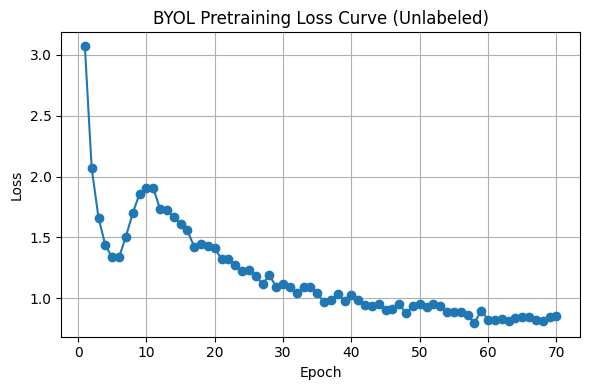

📈 Loss curve saved as 'byol_loss_curve.png'


In [2]:
# Plot & save loss curve
plt.figure(figsize=(6,4))
plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
plt.title("BYOL Pretraining Loss Curve (Unlabeled)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True)
plt.tight_layout()
plt.savefig("byol_loss_curve.png", dpi=300)
plt.show()
print("📈 Loss curve saved as 'byol_loss_curve.png'")

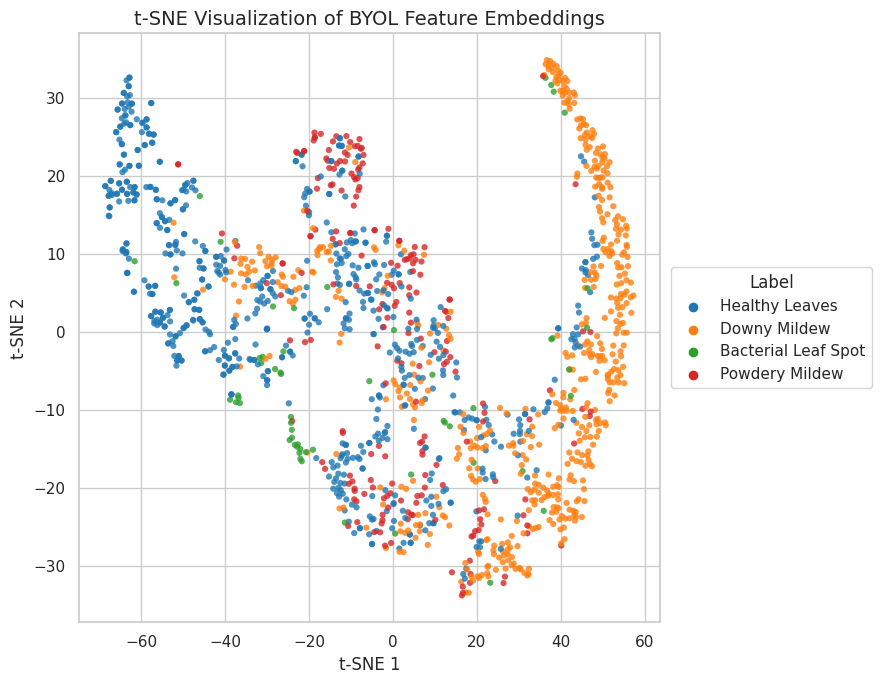

✅ t-SNE plot saved as 'byol_tsne_by_label.png' and shown inline


In [3]:
# ======================
# t-SNE on BYOL features (Corrected & Polished)
# ======================
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from torch.utils.data import Subset

# 1) Use a labeled split so we can color by class
ROOT_LABELED = cfg.ROOT_TRAIN  # or cfg.PATH_VALID if you want validation set

eval_tf = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

labeled_ds = datasets.ImageFolder(ROOT_LABELED, transform=eval_tf)

# Optional subsample for speed
idxs = list(range(len(labeled_ds)))
if cfg.MAX_TSNE_IMAGES is not None and len(idxs) > cfg.MAX_TSNE_IMAGES:
    idxs = random.sample(idxs, cfg.MAX_TSNE_IMAGES)

subset = Subset(labeled_ds, idxs)
loader = DataLoader(subset, batch_size=64, shuffle=False,
                    num_workers=cfg.num_workers, pin_memory=cfg.pin_memory)

# 2) Extract features with the pretrained encoder
enc = model.online_enc.to(device).eval()   # BYOL encoder
for p in enc.parameters(): 
    p.requires_grad = False

features, labels = [], []
with torch.no_grad():
    for x, y in loader:
        x = x.to(device)
        f = enc(x)                 # (B, 2048) for ResNet50 with fc=Identity()
        features.append(f.cpu().numpy())
        labels.append(y.numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# 3) t-SNE
tsne_2d = TSNE(
    n_components=2,
    perplexity=30,
    init="pca",
    learning_rate="auto",
    random_state=cfg.seed
).fit_transform(features)

# 4) DataFrame for plotting
df = pd.DataFrame(tsne_2d, columns=["x", "y"])
class_names = labeled_ds.classes
df["label"] = [class_names[i] for i in labels]

# 5) Plot (prettier style)
plt.figure(figsize=(9, 7))
sns.set(style="whitegrid", context="notebook")
sns.scatterplot(
    data=df, x="x", y="y", hue="label",
    s=20, alpha=0.8, palette="tab10", edgecolor="none"
)
plt.title("t-SNE Visualization of BYOL Feature Embeddings", fontsize=14)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Label", bbox_to_anchor=(1.02, 0.5), loc="center left", borderaxespad=0.0)
plt.tight_layout()

# Save + show
plt.savefig("byol_tsne_by_label.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ t-SNE plot saved as 'byol_tsne_by_label.png' and shown inline")


Silhouette (PCA 2D):  -0.018
Silhouette (t-SNE 2D): 0.018


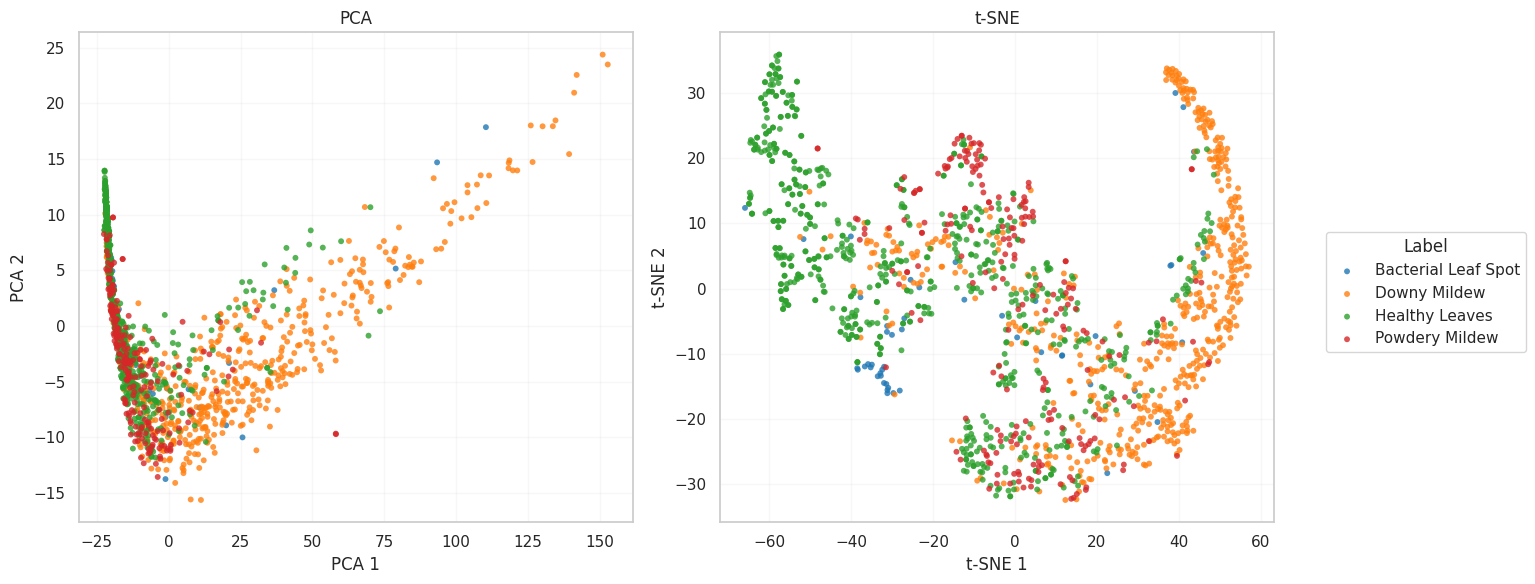

🖼️ Saved side-by-side figure as 'byol_pca_vs_tsne.png'


In [4]:
# ================================
# PCA vs t-SNE on BYOL embeddings
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from torch.utils.data import Subset

# 0) Build a labeled subset (reuse your cfg / device)
ROOT_LABELED = cfg.ROOT_TRAIN  # or cfg.PATH_VALID
eval_tf = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
labeled_ds = datasets.ImageFolder(ROOT_LABELED, transform=eval_tf)
class_names = labeled_ds.classes

idxs = list(range(len(labeled_ds)))
if getattr(cfg, "MAX_TSNE_IMAGES", None) is not None and len(idxs) > cfg.MAX_TSNE_IMAGES:
    idxs = random.sample(idxs, cfg.MAX_TSNE_IMAGES)
subset = Subset(labeled_ds, idxs)

loader = DataLoader(subset, batch_size=64, shuffle=False,
                    num_workers=cfg.num_workers, pin_memory=cfg.pin_memory)

# 1) Extract BYOL features (2048-d) with frozen encoder
#    Use your trained BYOL online encoder; adjust if your var is different.
enc = model.online_enc.to(device).eval()
for p in enc.parameters(): p.requires_grad = False

feats, labs = [], []
with torch.no_grad():
    for x, y in loader:
        x = x.to(device)
        f = enc(x)       # shape [B, 2048] if resnet50 with fc=Identity()
        feats.append(f.cpu().numpy()); labs.append(y.numpy())
features = np.concatenate(feats, axis=0)
labels = np.concatenate(labs, axis=0)

# 2) 2D projections
pca_2d  = PCA(n_components=2, random_state=cfg.seed).fit_transform(features)
tsne_2d = TSNE(n_components=2, perplexity=30, init="pca",
               learning_rate="auto", random_state=cfg.seed).fit_transform(features)

# 3) Silhouette scores (in 2D projected spaces)
sil_pca  = silhouette_score(pca_2d,  labels)
sil_tsne = silhouette_score(tsne_2d, labels)
print(f"Silhouette (PCA 2D):  {sil_pca:.3f}")
print(f"Silhouette (t-SNE 2D): {sil_tsne:.3f}")

# 4) Plot side-by-side
sns.set(style="whitegrid", context="notebook")
palette = sns.color_palette("tab10", n_colors=len(class_names))

fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharex=False, sharey=False)

def scatter(ax, Z, title):
    for ci, cname in enumerate(class_names):
        m = (labels == ci)
        ax.scatter(Z[m,0], Z[m,1], s=18, alpha=0.8, color=palette[ci], label=cname, edgecolors="none")
    ax.set_title(title)
    ax.set_xlabel(f"{title} 1")
    ax.set_ylabel(f"{title} 2")
    ax.grid(True, alpha=0.15)

scatter(axes[0], pca_2d,  "PCA")
scatter(axes[1], tsne_2d, "t-SNE")

# One legend outside for both
handles, lbls = axes[1].get_legend_handles_labels()
fig.legend(handles, lbls, title="Label", loc="center left", bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.savefig("byol_pca_vs_tsne.png", dpi=300, bbox_inches="tight")
plt.show()

print("🖼️ Saved side-by-side figure as 'byol_pca_vs_tsne.png'")


In [5]:
import os, time, math, random
from dataclasses import dataclass
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# -----------------------
# Config
# -----------------------
@dataclass
class CFG:
    PATH_TRAIN: str = "/kaggle/input/datasetleaf77/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset train"
    PATH_VALID: str = "/kaggle/input/datasetleaf77/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset validate"
    ENCODER_PATH: str = "/kaggle/working/byol_encoder.pth"  # BYOL-pretrained encoder (from self-supervised PRETRAIN stage)

    img_size: int = 224
    batch_size: int = 32
    num_workers: int = 0
    pin_memory: bool = False

    epochs: int = 70
    lr: float = 1e-3
    weight_decay: float = 1e-4
    warmup_epochs: int = 1
    freeze_epochs: int = 1     # freeze encoder for first N epochs, then unfreeze
    label_smoothing: float = 0.0
    seed: int = 42

cfg = CFG()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------
# Reproducibility
# -----------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
set_seed(cfg.seed)

# -----------------------
# DOWNSTREAM TASK: Supervised Dataset (classification)
# -----------------------
mean = [0.485, 0.456, 0.406]; std = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(cfg.img_size, scale=(0.8, 1.0), ratio=(3/4, 4/3)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(0.2,0.2,0.1,0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(cfg.img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_ds = datasets.ImageFolder(cfg.PATH_TRAIN, transform=train_tf)
valid_ds = datasets.ImageFolder(cfg.PATH_VALID, transform=eval_tf)

num_classes = len(train_ds.classes)
print("Classes:", train_ds.classes)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,
                          num_workers=cfg.num_workers, pin_memory=cfg.pin_memory)
valid_loader = DataLoader(valid_ds, batch_size=cfg.batch_size, shuffle=False,
                          num_workers=cfg.num_workers, pin_memory=cfg.pin_memory)

# -----------------------
# DOWNSTREAM TASK: Load BYOL encoder and attach classifier head
# -----------------------
def build_resnet50_encoder():
    enc = models.resnet50(weights=None)
    feat_dim = enc.fc.in_features  # 2048
    enc.fc = nn.Identity()
    return enc, feat_dim

encoder, feat_dim = build_resnet50_encoder()
state = torch.load(cfg.ENCODER_PATH, map_location="cpu")
missing, unexpected = encoder.load_state_dict(state, strict=False)
print("Loaded BYOL encoder (from PRETRAIN). Missing keys:", missing, "| Unexpected:", unexpected)

class Classifier(nn.Module):
    def __init__(self, encoder, feat_dim, n_classes):
        super().__init__()
        self.encoder = encoder
        self.head = nn.Linear(feat_dim, n_classes)
    def forward(self, x):
        feats = self.encoder(x)
        return self.head(feats)

# Full downstream model = frozen encoder + linear head
model = Classifier(encoder, feat_dim, num_classes).to(device)

# -----------------------
# DOWNSTREAM TRAINING SETUP
# -----------------------
def set_encoder_trainable(m, on: bool):
    for p in m.parameters(): p.requires_grad = on

# Start with encoder frozen (linear eval warmup)
set_encoder_trainable(model.encoder, False)

def make_optimizer(lr):
    params = [p for p in model.parameters() if p.requires_grad]
    return torch.optim.AdamW(params, lr=lr, weight_decay=cfg.weight_decay)

optimizer = make_optimizer(cfg.lr)
criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing).to(device)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

# Cosine LR schedule
def lr_at(epoch, max_epochs, base_lr, warmup_epochs=0, final_scale=0.05):
    if epoch < warmup_epochs:
        return base_lr * (epoch + 1) / max(1, warmup_epochs)
    t = (epoch - warmup_epochs) / max(1, max_epochs - warmup_epochs - 1)
    return base_lr * (final_scale + 0.5 * (1 - final_scale) * (1 + math.cos(math.pi * t)))

# -----------------------
# Training loop (DOWNSTREAM)
# -----------------------
BAR_FMT = "{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]"

def run_epoch(loader, train: bool, desc: str):
    model.train() if train else model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    pbar = tqdm(total=len(loader), desc=desc, leave=True, miniters=1, dynamic_ncols=True, bar_format=BAR_FMT)
    with torch.set_grad_enabled(train):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            if train: optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(x)
                loss = criterion(logits, y)
            if train:
                scaler.scale(loss).backward()
                scaler.step(optimizer); scaler.update()
            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total += x.size(0)
            pbar.set_postfix(loss=f"{(total_loss/total):.4f}", acc=f"{(total_correct/total)*100:.2f}%")
            pbar.update(1)
    pbar.close()
    return total_loss/total, total_correct/total

train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

for epoch in range(cfg.epochs):
    # Unfreeze encoder after N warmup epochs → full fine-tuning
    if epoch == cfg.freeze_epochs:
        set_encoder_trainable(model.encoder, True)
        optimizer = make_optimizer(cfg.lr * 0.3)

    # Update LR
    lr_now = lr_at(epoch, cfg.epochs, optimizer.param_groups[0]["lr"], warmup_epochs=cfg.warmup_epochs)
    for pg in optimizer.param_groups: pg["lr"] = lr_now

    tr_loss, tr_acc = run_epoch(train_loader, train=True,  desc=f"Epoch {epoch+1}/{cfg.epochs} (Train)")
    va_loss, va_acc = run_epoch(valid_loader, train=False, desc=f"Epoch {epoch+1}/{cfg.epochs} (Valid)")

    train_losses.append(tr_loss); valid_losses.append(va_loss)
    train_accs.append(tr_acc);    valid_accs.append(va_acc)

    print(f"Epoch {epoch+1}: Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f}, "
          f"Val Loss: {va_loss:.4f}, Val Acc: {va_acc:.4f}")

# -----------------------
# Final downstream evaluation
# -----------------------
final_train_acc = train_accs[-1] * 100.0
final_val_acc   = valid_accs[-1] * 100.0
print(f"\n✅ Final Train Accuracy : {final_train_acc:.2f}%")
print(f"✅ Final Validation Accuracy : {final_val_acc:.2f}%\n")

# -----------------------
# Save downstream fine-tuned model
# -----------------------
torch.save(model.state_dict(), "finetuned_classifier.pth")
print("💾 Downstream fine-tuned model saved as 'finetuned_classifier.pth'")


Classes: ['Bacterial Leaf Spot', 'Downy Mildew', 'Healthy Leaves', 'Powdery Mildew']
Loaded BYOL encoder (from PRETRAIN). Missing keys: [] | Unexpected: []


/tmp/ipykernel_36/3674462136.py:118: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Epoch 1/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

/tmp/ipykernel_36/3674462136.py:140: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 1/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1: Train Loss: 1.0391, Train Acc: 0.6253, Val Loss: 1.0485, Val Acc: 0.5550


Epoch 2/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 2/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.7169, Train Acc: 0.7165, Val Loss: 0.6049, Val Acc: 0.7579


Epoch 3/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 3/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.4899, Train Acc: 0.8097, Val Loss: 0.7449, Val Acc: 0.7628


Epoch 4/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 4/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.4090, Train Acc: 0.8532, Val Loss: 0.3716, Val Acc: 0.8484


Epoch 5/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 5/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.3076, Train Acc: 0.8947, Val Loss: 0.4302, Val Acc: 0.8411


Epoch 6/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 6/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.2326, Train Acc: 0.9198, Val Loss: 0.2688, Val Acc: 0.9022


Epoch 7/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 7/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.2412, Train Acc: 0.9240, Val Loss: 0.2037, Val Acc: 0.9364


Epoch 8/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 8/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.2157, Train Acc: 0.9287, Val Loss: 0.2116, Val Acc: 0.9144


Epoch 9/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 9/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.1828, Train Acc: 0.9408, Val Loss: 0.2451, Val Acc: 0.9144


Epoch 10/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 10/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.1739, Train Acc: 0.9376, Val Loss: 0.2845, Val Acc: 0.8924


Epoch 11/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 11/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11: Train Loss: 0.1992, Train Acc: 0.9350, Val Loss: 0.2634, Val Acc: 0.9022


Epoch 12/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 12/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12: Train Loss: 0.1529, Train Acc: 0.9439, Val Loss: 0.2091, Val Acc: 0.9169


Epoch 13/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 13/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13: Train Loss: 0.1351, Train Acc: 0.9612, Val Loss: 0.1481, Val Acc: 0.9487


Epoch 14/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 14/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14: Train Loss: 0.1289, Train Acc: 0.9544, Val Loss: 0.2841, Val Acc: 0.9120


Epoch 15/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 15/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15: Train Loss: 0.1121, Train Acc: 0.9612, Val Loss: 0.1912, Val Acc: 0.9487


Epoch 16/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 16/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16: Train Loss: 0.0953, Train Acc: 0.9612, Val Loss: 0.1219, Val Acc: 0.9511


Epoch 17/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 17/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17: Train Loss: 0.0994, Train Acc: 0.9696, Val Loss: 0.1242, Val Acc: 0.9487


Epoch 18/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 18/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18: Train Loss: 0.0959, Train Acc: 0.9691, Val Loss: 0.1084, Val Acc: 0.9584


Epoch 19/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 19/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19: Train Loss: 0.0626, Train Acc: 0.9775, Val Loss: 0.0993, Val Acc: 0.9658


Epoch 20/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 20/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20: Train Loss: 0.0736, Train Acc: 0.9748, Val Loss: 0.1553, Val Acc: 0.9389


Epoch 21/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 21/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 21: Train Loss: 0.0703, Train Acc: 0.9748, Val Loss: 0.1079, Val Acc: 0.9633


Epoch 22/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 22/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 22: Train Loss: 0.0560, Train Acc: 0.9811, Val Loss: 0.1096, Val Acc: 0.9535


Epoch 23/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 23/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 23: Train Loss: 0.0371, Train Acc: 0.9911, Val Loss: 0.0737, Val Acc: 0.9756


Epoch 24/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 24/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 24: Train Loss: 0.0410, Train Acc: 0.9858, Val Loss: 0.0756, Val Acc: 0.9731


Epoch 25/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 25/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 25: Train Loss: 0.0377, Train Acc: 0.9869, Val Loss: 0.0919, Val Acc: 0.9584


Epoch 26/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 26/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 26: Train Loss: 0.0456, Train Acc: 0.9817, Val Loss: 0.0879, Val Acc: 0.9584


Epoch 27/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 27/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 27: Train Loss: 0.0342, Train Acc: 0.9906, Val Loss: 0.0873, Val Acc: 0.9584


Epoch 28/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 28/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 28: Train Loss: 0.0385, Train Acc: 0.9864, Val Loss: 0.0795, Val Acc: 0.9658


Epoch 29/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 29/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 29: Train Loss: 0.0317, Train Acc: 0.9906, Val Loss: 0.0825, Val Acc: 0.9658


Epoch 30/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 30/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30: Train Loss: 0.0320, Train Acc: 0.9895, Val Loss: 0.0770, Val Acc: 0.9658


Epoch 31/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 31/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 31: Train Loss: 0.0230, Train Acc: 0.9937, Val Loss: 0.0727, Val Acc: 0.9682


Epoch 32/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 32/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 32: Train Loss: 0.0246, Train Acc: 0.9927, Val Loss: 0.0830, Val Acc: 0.9633


Epoch 33/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 33/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 33: Train Loss: 0.0234, Train Acc: 0.9932, Val Loss: 0.0656, Val Acc: 0.9682


Epoch 34/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 34/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 34: Train Loss: 0.0319, Train Acc: 0.9906, Val Loss: 0.0940, Val Acc: 0.9560


Epoch 35/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 35/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 35: Train Loss: 0.0318, Train Acc: 0.9874, Val Loss: 0.0669, Val Acc: 0.9682


Epoch 36/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 36/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 36: Train Loss: 0.0292, Train Acc: 0.9900, Val Loss: 0.0767, Val Acc: 0.9658


Epoch 37/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 37/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 37: Train Loss: 0.0276, Train Acc: 0.9911, Val Loss: 0.0752, Val Acc: 0.9658


Epoch 38/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 38/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 38: Train Loss: 0.0356, Train Acc: 0.9890, Val Loss: 0.0673, Val Acc: 0.9682


Epoch 39/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 39/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 39: Train Loss: 0.0359, Train Acc: 0.9858, Val Loss: 0.0750, Val Acc: 0.9658


Epoch 40/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 40/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 40: Train Loss: 0.0343, Train Acc: 0.9864, Val Loss: 0.0739, Val Acc: 0.9658


Epoch 41/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 41/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 41: Train Loss: 0.0262, Train Acc: 0.9921, Val Loss: 0.0787, Val Acc: 0.9658


Epoch 42/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 42/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 42: Train Loss: 0.0323, Train Acc: 0.9900, Val Loss: 0.0707, Val Acc: 0.9682


Epoch 43/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 43/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 43: Train Loss: 0.0348, Train Acc: 0.9890, Val Loss: 0.0865, Val Acc: 0.9633


Epoch 44/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 44/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 44: Train Loss: 0.0269, Train Acc: 0.9895, Val Loss: 0.0773, Val Acc: 0.9633


Epoch 45/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 45/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 45: Train Loss: 0.0278, Train Acc: 0.9921, Val Loss: 0.0746, Val Acc: 0.9658


Epoch 46/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 46/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 46: Train Loss: 0.0294, Train Acc: 0.9885, Val Loss: 0.0829, Val Acc: 0.9658


Epoch 47/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 47/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 47: Train Loss: 0.0290, Train Acc: 0.9927, Val Loss: 0.0731, Val Acc: 0.9658


Epoch 48/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 48/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 48: Train Loss: 0.0299, Train Acc: 0.9900, Val Loss: 0.0859, Val Acc: 0.9633


Epoch 49/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 49/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 49: Train Loss: 0.0354, Train Acc: 0.9895, Val Loss: 0.0782, Val Acc: 0.9658


Epoch 50/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 50/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 50: Train Loss: 0.0239, Train Acc: 0.9932, Val Loss: 0.0747, Val Acc: 0.9658


Epoch 51/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 51/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 51: Train Loss: 0.0369, Train Acc: 0.9874, Val Loss: 0.0709, Val Acc: 0.9658


Epoch 52/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 52/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 52: Train Loss: 0.0357, Train Acc: 0.9879, Val Loss: 0.0803, Val Acc: 0.9658


Epoch 53/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 53/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 53: Train Loss: 0.0338, Train Acc: 0.9895, Val Loss: 0.0674, Val Acc: 0.9682


Epoch 54/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 54/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 54: Train Loss: 0.0329, Train Acc: 0.9885, Val Loss: 0.0645, Val Acc: 0.9707


Epoch 55/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 55/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 55: Train Loss: 0.0301, Train Acc: 0.9906, Val Loss: 0.0843, Val Acc: 0.9633


Epoch 56/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 56/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 56: Train Loss: 0.0212, Train Acc: 0.9958, Val Loss: 0.0742, Val Acc: 0.9633


Epoch 57/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 57/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 57: Train Loss: 0.0402, Train Acc: 0.9853, Val Loss: 0.0712, Val Acc: 0.9658


Epoch 58/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 58/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 58: Train Loss: 0.0310, Train Acc: 0.9885, Val Loss: 0.0787, Val Acc: 0.9658


Epoch 59/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 59/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 59: Train Loss: 0.0398, Train Acc: 0.9890, Val Loss: 0.0789, Val Acc: 0.9658


Epoch 60/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 60/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 60: Train Loss: 0.0282, Train Acc: 0.9900, Val Loss: 0.0773, Val Acc: 0.9658


Epoch 61/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 61/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 61: Train Loss: 0.0300, Train Acc: 0.9911, Val Loss: 0.0687, Val Acc: 0.9682


Epoch 62/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 62/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 62: Train Loss: 0.0344, Train Acc: 0.9879, Val Loss: 0.0805, Val Acc: 0.9633


Epoch 63/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 63/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 63: Train Loss: 0.0288, Train Acc: 0.9921, Val Loss: 0.0864, Val Acc: 0.9633


Epoch 64/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 64/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 64: Train Loss: 0.0210, Train Acc: 0.9958, Val Loss: 0.0742, Val Acc: 0.9658


Epoch 65/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 65/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 65: Train Loss: 0.0334, Train Acc: 0.9895, Val Loss: 0.0770, Val Acc: 0.9658


Epoch 66/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 66/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 66: Train Loss: 0.0302, Train Acc: 0.9916, Val Loss: 0.0824, Val Acc: 0.9633


Epoch 67/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 67/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 67: Train Loss: 0.0217, Train Acc: 0.9921, Val Loss: 0.0804, Val Acc: 0.9633


Epoch 68/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 68/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 68: Train Loss: 0.0327, Train Acc: 0.9890, Val Loss: 0.0807, Val Acc: 0.9633


Epoch 69/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 69/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 69: Train Loss: 0.0260, Train Acc: 0.9927, Val Loss: 0.0777, Val Acc: 0.9658


Epoch 70/70 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 70/70 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 70: Train Loss: 0.0283, Train Acc: 0.9911, Val Loss: 0.0785, Val Acc: 0.9658

✅ Final Train Accuracy : 99.11%
✅ Final Validation Accuracy : 96.58%

💾 Downstream fine-tuned model saved as 'finetuned_classifier.pth'


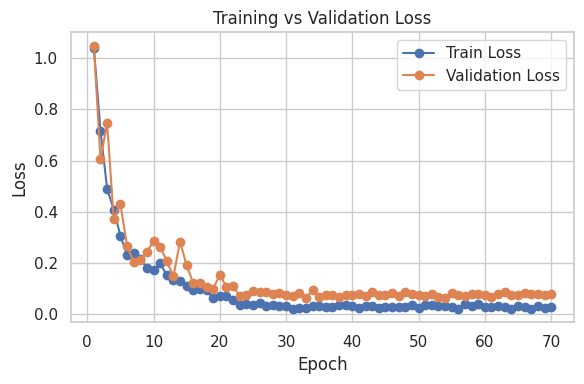

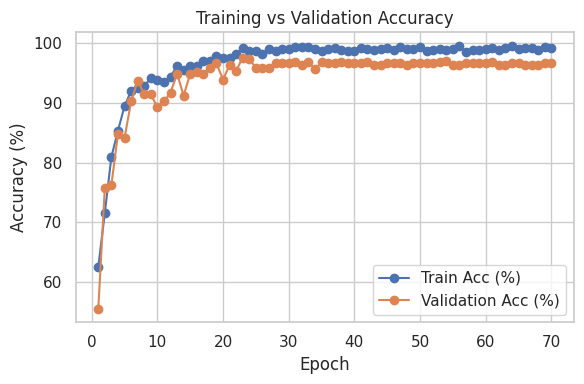

In [6]:
# -----------------------
# Plots: Train vs Validation
# -----------------------
plt.figure(figsize=(6,4))
plt.plot(range(1, cfg.epochs+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, cfg.epochs+1), valid_losses, marker='o', label='Validation Loss')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training vs Validation Loss")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig("train_val_loss.png", dpi=300); plt.show()

plt.figure(figsize=(6,4))
plt.plot(range(1, cfg.epochs+1), [a*100 for a in train_accs], marker='o', label='Train Acc (%)')
plt.plot(range(1, cfg.epochs+1), [a*100 for a in valid_accs], marker='o', label='Validation Acc (%)')
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Training vs Validation Accuracy")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig("train_val_acc.png", dpi=300); plt.show()

In [7]:
# ========= 2.4 Downstream Fine-tuning — LAST PART: TEST EVALUATION =========
# Uses fine-tuned model weights: /kaggle/working/finetuned_classifier.pth
# Outputs:
#  - Overall Test Accuracy + Total testing time
#  - Per-class total time (s) and avg time per image (ms)
#  - (Optional) Classification report
#  - (Optional) Confusion matrix plot saved to /kaggle/working/confusion_matrix.png

import os, time, itertools, math, random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_fscore_support, accuracy_score
)
from sklearn.preprocessing import label_binarize

# -----------------------
# Paths & config
# -----------------------
FINETUNED_PATH = "/kaggle/working/finetuned_classifier.pth"
PATH_TEST = "/kaggle/input/datasetleaf77/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset test"
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 0      # keep 0 in Kaggle notebooks to avoid multiprocessing warnings
PIN_MEMORY = False
SEED = 42

# -----------------------
# Repro & device
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -----------------------
# Data (test only)
# -----------------------
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_ds = datasets.ImageFolder(PATH_TEST, transform=eval_tf)
test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
)
class_names = test_ds.classes
num_classes = len(class_names)
print("Classes:", class_names)

# -----------------------
# Rebuild model exactly like fine-tuning: encoder + linear head
# -----------------------
def build_resnet50_encoder():
    enc = models.resnet50(weights=None)   # same skeleton as during fine-tune
    feat_dim = enc.fc.in_features         # 2048
    enc.fc = nn.Identity()
    return enc, feat_dim

class Classifier(nn.Module):
    def __init__(self, encoder, feat_dim, n_classes):
        super().__init__()
        self.encoder = encoder
        self.head = nn.Linear(feat_dim, n_classes)
    def forward(self, x):
        feats = self.encoder(x)
        return self.head(feats)

encoder, feat_dim = build_resnet50_encoder()
model = Classifier(encoder, feat_dim, num_classes).to(device)

# -----------------------
# Load fine-tuned weights
# -----------------------
state = torch.load(FINETUNED_PATH, map_location="cpu")
missing, unexpected = model.load_state_dict(state, strict=False)
print("Loaded fine-tuned model.")
if missing:
    print(" > Missing keys:", missing)
if unexpected:
    print(" > Unexpected keys:", unexpected)

# -----------------------
# Helper: logits/targets + per-class timing
# -----------------------
@torch.no_grad()
def collect_logits_targets_and_timing(loader, num_classes):
    model.eval()
    all_logits, all_targets = [], []
    class_time = np.zeros(num_classes, dtype=np.float64)   # total seconds per class
    class_counts = np.zeros(num_classes, dtype=np.int64)   # number of samples per class

    total_start = time.perf_counter()
    for x, y in loader:
        x = x.to(device, non_blocking=True)

        # accurate batch timing (esp. on GPU)
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        batch_start = time.perf_counter()

        logits = model(x)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        batch_end = time.perf_counter()

        batch_time = batch_end - batch_start
        bs = y.size(0)
        per_sample_time = batch_time / max(bs, 1)

        # accumulate per-class time by true label
        for lbl in y.tolist():
            class_time[lbl] += per_sample_time
            class_counts[lbl] += 1

        all_logits.append(logits.detach().cpu())
        all_targets.append(y)

    total_end = time.perf_counter()
    total_time = total_end - total_start

    all_logits = torch.cat(all_logits)
    all_targets = torch.cat(all_targets)
    return all_logits, all_targets, class_time, class_counts, total_time

# -----------------------
# TEST EVALUATION + timing (overall + per-class)
# -----------------------
test_logits, test_targets, class_time, class_counts, test_time_sec = \
    collect_logits_targets_and_timing(test_loader, num_classes)

test_probs = torch.softmax(test_logits, dim=1).numpy()
test_preds = test_logits.argmax(dim=1).numpy()
test_targets_np = test_targets.numpy()

# Overall Test Accuracy
test_acc = accuracy_score(test_targets_np, test_preds)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"⏱️ Total testing time (all samples): {test_time_sec:.3f} seconds")

# Per-class timing (total & average per image)
print("\n⏱️ Per-class testing time:")
print(f"{'Class':30s} {'Count':>6s} {'Total (s)':>12s} {'Avg/Image (ms)':>16s}")
for idx, name in enumerate(class_names):
    cnt = int(class_counts[idx])
    tot = float(class_time[idx])
    avg_ms = (tot / cnt * 1000.0) if cnt > 0 else 0.0
    print(f"{name:30s} {cnt:6d} {tot:12.6f} {avg_ms:16.3f}")



Classes: ['Bacterial Leaf Spot', 'Downy Mildew', 'Healthy Leaves', 'Powdery Mildew']
Loaded fine-tuned model.

✅ Test Accuracy: 92.67%
⏱️ Total testing time (all samples): 4.329 seconds

⏱️ Per-class testing time:
Class                           Count    Total (s)   Avg/Image (ms)
Bacterial Leaf Spot                15     0.055202            3.680
Downy Mildew                      145     0.434135            2.994
Healthy Leaves                    188     0.518722            2.759
Powdery Mildew                     61     0.167942            2.753


Class 'Bacterial Leaf Spot': accuracy = 93.33%
Class 'Downy Mildew': accuracy = 92.41%
Class 'Healthy Leaves': accuracy = 100.00%
Class 'Powdery Mildew': accuracy = 70.49%

Classification Report (per-class):
                     precision    recall  f1-score   support

Bacterial Leaf Spot       0.82      0.93      0.87        15
       Downy Mildew       0.96      0.92      0.94       145
     Healthy Leaves       0.92      1.00      0.96       188
     Powdery Mildew       0.90      0.70      0.79        61

           accuracy                           0.93       409
          macro avg       0.90      0.89      0.89       409
       weighted avg       0.93      0.93      0.92       409

Macro   Precision/Recall/F1: 0.900 / 0.891 / 0.891
Micro   Precision/Recall/F1: 0.927 / 0.927 / 0.927
Weighted Precision/Recall/F1: 0.927 / 0.927 / 0.924


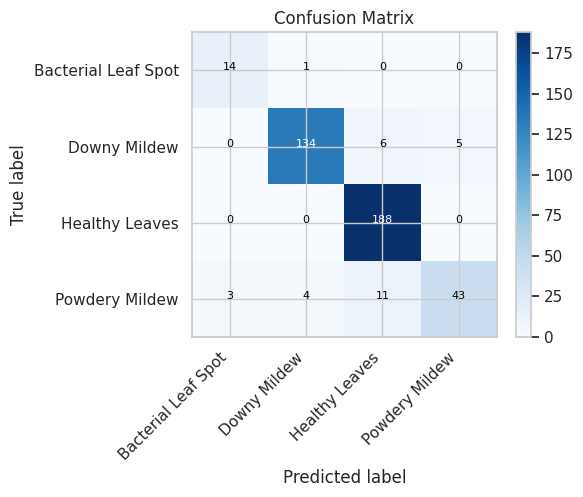

🖼️ Saved 'confusion_matrix.png'


In [11]:
# Per-class Accuracy
cm = confusion_matrix(test_targets_np, test_preds, labels=list(range(num_classes)))
per_class_acc = cm.diagonal() / cm.sum(axis=1).clip(min=1)
for i, cname in enumerate(class_names):
    print(f"Class '{cname}': accuracy = {per_class_acc[i]*100:.2f}%")

# Precision / Recall / F1 (macro, micro, weighted) + per-class table
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    test_targets_np, test_preds, average='macro', zero_division=0)
prec_micro, rec_micro, f1_micro, _ = precision_recall_fscore_support(
    test_targets_np, test_preds, average='micro', zero_division=0)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
    test_targets_np, test_preds, average='weighted', zero_division=0)

from sklearn.metrics import classification_report
print("\nClassification Report (per-class):")
print(classification_report(test_targets_np, test_preds, target_names=class_names, zero_division=0))

print(f"Macro   Precision/Recall/F1: {prec_macro:.3f} / {rec_macro:.3f} / {f1_macro:.3f}")
print(f"Micro   Precision/Recall/F1: {prec_micro:.3f} / {rec_micro:.3f} / {f1_micro:.3f}")
print(f"Weighted Precision/Recall/F1: {prec_weighted:.3f} / {rec_weighted:.3f} / {f1_weighted:.3f}")




# -----------------------
# Confusion Matrix plot
# -----------------------
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.0
for i, j in itertools.product(range(num_classes), range(num_classes)):
    plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black", fontsize=8)
plt.ylabel('True label'); plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300); plt.show()
print("🖼️ Saved 'confusion_matrix.png'")


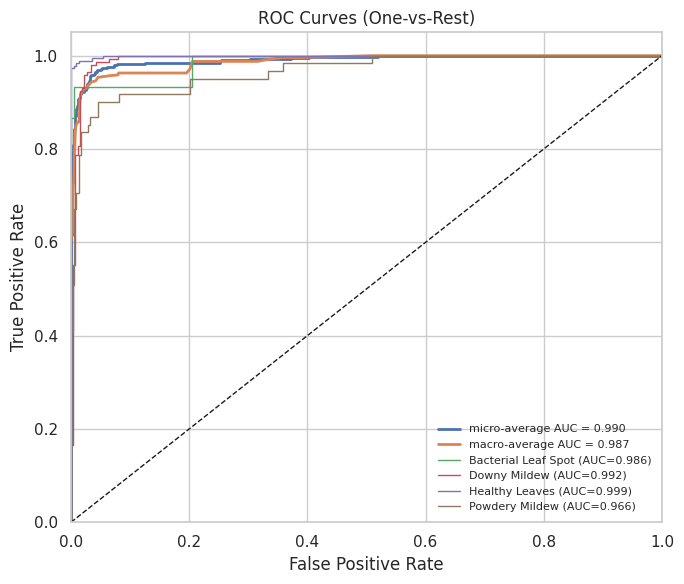

🖼️ Saved 'roc_auc_curves.png'


In [12]:
# -----------------------
# ROC curves + AUC (One-vs-Rest)
# -----------------------
# Binarize labels for ROC/AUC
y_true_bin = label_binarize(test_targets_np, classes=list(range(num_classes)))
if y_true_bin.shape[1] == 1:
    # In binary case, expand to 2 columns for ROC plotting
    y_true_bin = np.hstack([1 - y_true_bin, y_true_bin])

fpr = {}; tpr = {}; roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), test_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average AUC = {roc_auc['micro']:.3f}", linewidth=2)
plt.plot(all_fpr, mean_tpr, label=f"macro-average AUC = {roc_auc['macro']:.3f}", linewidth=2)
for i, cname in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], lw=1, label=f"{cname} (AUC={roc_auc[i]:.3f})")
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(fontsize=8, loc="lower right", frameon=False)
plt.tight_layout()
plt.savefig("roc_auc_curves.png", dpi=300); plt.show()
print("🖼️ Saved 'roc_auc_curves.png'")


